### Semi-autonomous Teleoperation Demo : Place task in `Kitchen Plate` scene with `small size dish rack`

### Parse `Realistic Scene`

In [1]:
import mujoco,cv2,pyvista
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../../../')
from utils.mujoco_parser import MuJoCoParserClass

from utils.util import sample_xyzs,rpy2r,r2rpy,r2quat,compute_view_params,get_interp_const_vel_traj, printmd
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[2.3.7]


In [2]:
xml_path = '../../../asset/scene_kitchen_dish_rack_small.xml'
env = MuJoCoParserClass(name='Place task scene: Plate table',rel_xml_path=xml_path,VERBOSE=False, MODE='window')
print(env.MODE)

# Move tables and robot base
env.model.body('base_table').pos = np.array([0,0,0])
env.model.body('base').pos = np.array([0.18,0,0.79])
env.model.body('avoiding_object_table').pos = np.array([0.38+0.45,0,0])
env.model.body('right_object_table').pos = np.array([-0.05,-0.80,0])
env.model.body('left_object_table').pos = np.array([-1.5,80,0])

# Place objects
obj_box_names = [body_name for body_name in env.body_names
             if body_name is not None and (body_name.startswith("obj_box"))]
n_box_obj = len(obj_box_names)
env.place_objects_random(n_obj=n_box_obj, obj_names=obj_box_names, x_range=[0.80, 1.15], y_range=[-3.15, -2.15], COLORS=False, VERBOSE=True)

jntadr_mug_cup = env.model.body('mug_cup').jntadr[0]
env.model.joint(jntadr_mug_cup).qpos0[:3] = np.array([ -0.9, -30, 0.85])
env.model.joint(jntadr_mug_cup).qpos0[3:] = r2quat(rpy2r(np.radians([0, 0, np.random.rand() * 360])))

jntadr_tray = env.model.body('tray').jntadr[0]
env.model.joint(jntadr_tray).qpos0[:3] = np.array([-0.9,-30,0.80])
# env.model.joint(jntadr_tray).qpos0[3:] = r2quat(rpy2r(np.radians([0, 0, 0])))

jntadr_dish_rack = env.model.body('rack_base').jntadr[0]
pos_dish_rack = np.array([0.9,0.35,0.82])
env.model.joint(jntadr_dish_rack).qpos0[:3] = pos_dish_rack
dish_rack_random_rot = 0 # np.random.rand() * 360
env.model.joint(jntadr_dish_rack).qpos0[3:] = r2quat(rpy2r(np.radians([0, 0, dish_rack_random_rot])))


# Target dish
env.model.joint(env.model.body('kitchen-plate').jntadr[0]).qpos0[:3] = np.array([0.2, -0.7, 0.8])
# Set the dishes
env.model.joint(env.model.body('kitchen-plate-2').jntadr[0]).qpos0[:3] = pos_dish_rack + np.array([0.,0.0, 0.15])
env.model.joint(env.model.body('kitchen-plate-2').jntadr[0]).qpos0[3:] = r2quat(rpy2r(np.radians([0, 90, 90])))
env.model.joint(env.model.body('kitchen-plate-3').jntadr[0]).qpos0[:3] = pos_dish_rack + np.array([0., -0.1, 0.15])
env.model.joint(env.model.body('kitchen-plate-3').jntadr[0]).qpos0[3:] = r2quat(rpy2r(np.radians([0, 90, 90])))
env.model.joint(env.model.body('kitchen-plate-4').jntadr[0]).qpos0[:3] = pos_dish_rack + np.array([-2.5, 0.1, 0.15])
env.model.joint(env.model.body('kitchen-plate-4').jntadr[0]).qpos0[3:] = r2quat(rpy2r(np.radians([0, 90, 90])))

env.reset()

window


[ 0.5  -0.01  1.16]
Pressed ESC
Quitting.


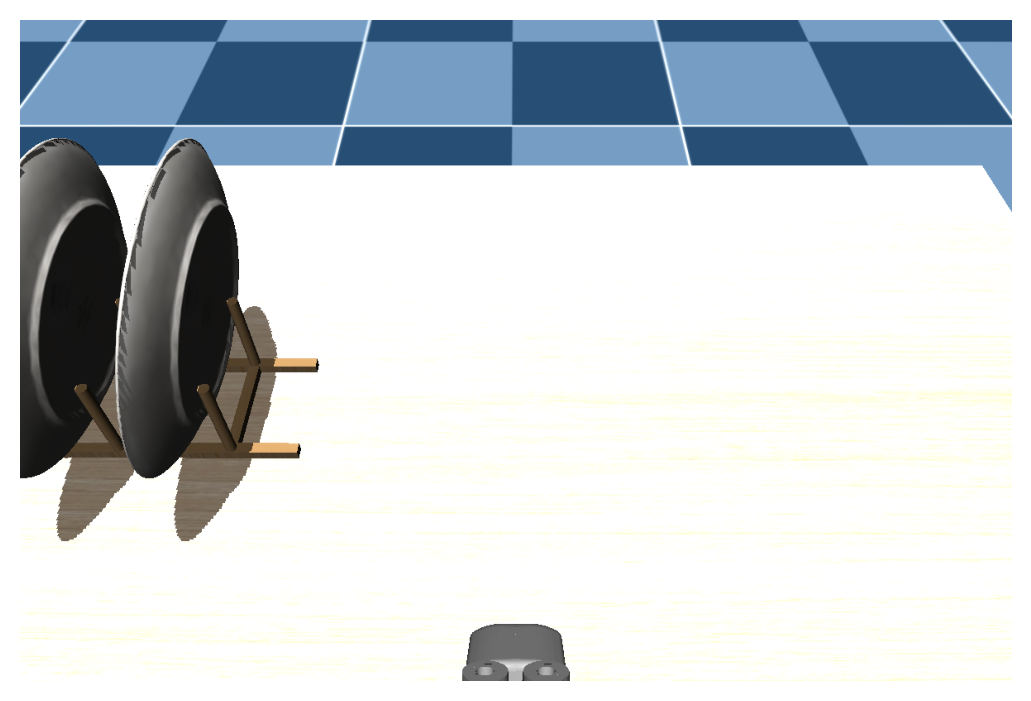

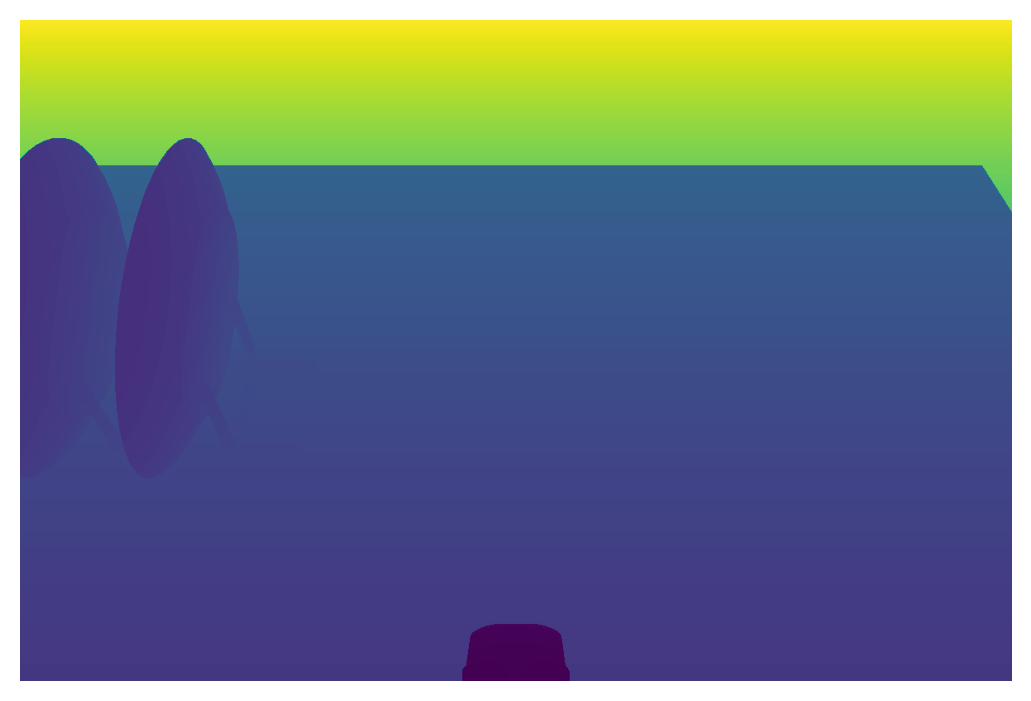

Done. Tick:[777] Time:[1.55]sec


In [3]:
# Init viewer
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True, MODE='window')
env.update_viewer(azimuth=150,distance=3.0,elevation=-30,lookat=[0.4,0.0,0.81],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.25,jointwidth=0.05,jointrgba=[0.2,0.6,0.8,0.6])

pcd_tick = 0

# Reset
env.reset()
init_ur_q = np.array([np.deg2rad(-90), np.deg2rad(-130), np.deg2rad(120), np.deg2rad(100), np.deg2rad(45), np.deg2rad(-90)])
env.forward(q=init_ur_q, joint_idxs=env.idxs_forward)
initial_xyz = env.get_p_body('tcp_link')
print(env.get_p_body('tcp_link'))
tick,max_sec = 0,1000
while env.get_sim_time() <= max_sec:
    env.step(ctrl=init_ur_q,ctrl_idxs=env.idxs_step)
    if not env.is_viewer_alive(): break

    # Render
    if env.loop_every(HZ=20):
        # Compute some poses
        p_tcp,R_tcp = env.get_pR_body(body_name='tcp_link')
        p_cam,R_cam = env.get_pR_body(body_name='camera_center')
        p_base,R_base = env.get_pR_body(body_name='base')
        # Get PCD from a specific view
        p_ego  = p_cam
        p_trgt = p_cam + R_cam[:,2] + np.array([0,0,-0.1])
        rgb_img,depth_img,pcd,xyz_img = env.get_egocentric_rgb_depth_pcd(
            p_ego=p_ego,p_trgt=p_trgt,rsz_rate=40,fovy=45,BACKUP_AND_RESTORE_VIEW=True)
        env.render(render_every=1)

plt.imshow(rgb_img); plt.axis('off'); plt.show()
plt.imshow(depth_img); plt.axis('off'); plt.show()

# Close viewer
env.close_viewer()
print ("Done. Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()))

In [11]:
from utils.util import passthrough_filter

test_pcd = np.load('./data_kitchen/small/filtered_pcd_exp_0914_.npy')
feai_pcd = np.load('./data_kitchen/small/feasible_pcd_exp_0914__c48_g4_worker48.npy')
feai_pcd = passthrough_filter(feai_pcd, axis=1, interval=[0.0, 0.8])

In [14]:
import time

# Init viewer
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True, MODE='window')
env.update_viewer(azimuth=0.,distance=1.5,elevation=-80,lookat=([0.44, 0.  , 1.33]),
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.25,jointwidth=0.05,jointrgba=[0.2,0.6,0.8,0.6])

env.reset()
# Start from initial configuration
capture_pose_q = np.array([np.deg2rad(-90), np.deg2rad(-132.46), np.deg2rad(122.85), np.deg2rad(99.65), np.deg2rad(45), np.deg2rad(-90.02)])
init_configurations = [-0.73418, -1.08485, 2.7836, -1.699, 0.8366, 0]
env.forward(q=capture_pose_q,joint_idxs=[0,1,2,3,4,5])

tick = 0
end_tick = 1500
perturb_tick = 500
target_obj_name = 'kitchen-plate' # 'coke'
target_cylinder_jntadr = env.model.body(target_obj_name).jntadr[0]
print(env.get_p_body(target_obj_name)[0])
p_list = []
R_list = []
feasible_place_positions = []
target_obj_jntadr = env.model.body(target_obj_name).jntadr[0]
target_obj_qposadr = env.model.jnt_qposadr[target_obj_jntadr]

env.set_figure(fig_idx=0, line_name="x", title="Joint position", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=0, line_name="y", title="Joint position", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=0, line_name="z", title="Joint position", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=1, line_name="Roll", title="Rotation", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=1, line_name="Pitch", title="Rotation", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=1, line_name="Yaw", title="Rotation", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=2, line_name="Q_w", title="Quat", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
# env.set_figure(fig_idx=2, line_name="Q_x", title="Quat", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
# env.set_figure(fig_idx=2, line_name="Q_y", title="Quat", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
# env.set_figure(fig_idx=2, line_name="Q_z", title="Quat", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)

for p in feai_pcd:
    p_list = []
    R_list = []
    quat_list = []
    p += np.array([0, 0, 0.0])
    print(f"Position: {p}")
    start = env.tick
    p_copy = p
    env.data.qpos[target_obj_qposadr:target_obj_qposadr+3] = p_copy
    env.data.qpos[target_obj_qposadr+3:target_obj_qposadr+7] = r2quat(rpy2r(np.radians([0, 90, 90])))
    while env.tick - start < end_tick:
        if not env.is_viewer_alive(): break
        env.forward(q=capture_pose_q,joint_idxs=[0,1,2,3,4,5])
        env.step(ctrl=capture_pose_q,ctrl_idxs=[0,1,2,3,4,5])
        R_obj = env.get_R_body(target_obj_name)
        quat_ = r2quat(R_obj)
        quat_list.append(quat_)
        env.plot_sphere(p=p_copy, r=0.005, rgba=[0,1,0,1], label=f"{env.tick}/{end_tick}")
        [env.plot_sphere(p=sampled_place_+[0,0,0.05], r=0.005, rgba=[0.7,0,0.7,0.1]) for sampled_place_ in feai_pcd]
        # [env.plot_sphere(p=sampled_place_+[0,0,0.05], r=0.005, rgba=[0.,1.,0.,0.1]) for sampled_place_ in test_pcd]

        env.plot_data(name="x", data=np.array(env.get_p_body(target_obj_name))[0], fig_idx=0)
        env.plot_data(name="y", data=np.array(env.get_p_body(target_obj_name))[1], fig_idx=0)
        env.plot_data(name="z", data=np.array(env.get_p_body(target_obj_name))[2], fig_idx=0)

        env.plot_data(name="Roll", data=r2rpy(env.get_R_body(target_obj_name))[0], fig_idx=1)
        env.plot_data(name="Pitch", data=r2rpy(env.get_R_body(target_obj_name))[1], fig_idx=1)
        env.plot_data(name="Yaw", data=r2rpy(env.get_R_body(target_obj_name))[2], fig_idx=1)
 
        env.plot_data(name="Q_w", data=env.data.qpos[target_obj_qposadr+3], fig_idx=2)
        # env.plot_data(name="Q_x", data=env.data.qpos[target_obj_qposadr+4], fig_idx=2)
        # env.plot_data(name="Q_y", data=env.data.qpos[target_obj_qposadr+5], fig_idx=2)
        # env.plot_data(name="Q_z", data=env.data.qpos[target_obj_qposadr+6], fig_idx=2)

        env.render(render_every=5)
        
    if not env.is_viewer_alive(): break    
    env.reset()
    lower_bound = 0.70
    upper_bound = 0.79
    in_range = np.logical_and(np.array(quat_list)[5:][:,0] >= lower_bound, np.array(quat_list)[5:][:,0] <= upper_bound)
    all_in_range = np.all(in_range)
    # print(f"all_in_range: {all_in_range}")
    print(f"max_qw: {np.max(np.array(quat_list)[5:][:,0])}")
    print(f"min_qw: {np.min(np.array(quat_list)[5:][:,0])}")

# Close viewer
env.close_viewer()
print ("Done. Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()))

0.2
Position: [0.85 0.29 0.95]
Pressed ESC
Quitting.
Done. Tick:[373] Time:[0.37]sec


### Define Reward based `KDE`

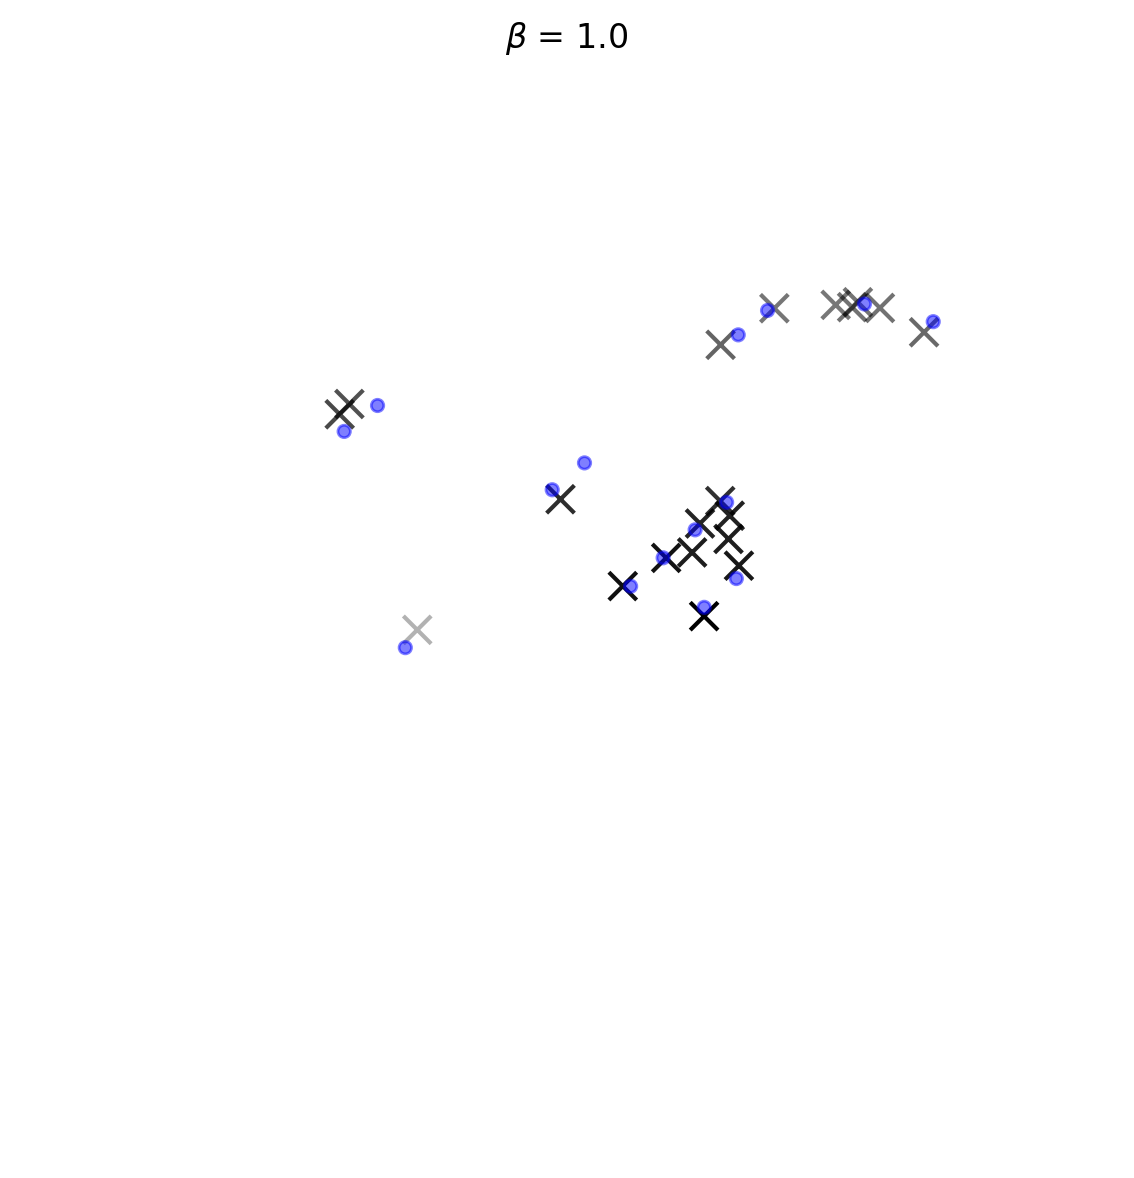

In [22]:
from scipy.stats import gaussian_kde

# Adjust the function to sample from 3D KDE with scaling and debugging
def sample_from_kde_3d_scaled(pcd, kde_values, num_samples=10):
    kde_values_flat = kde_values.flatten()
    kde_sum = np.sum(kde_values_flat)
    
    if np.isclose(kde_sum, 0):
        print(f"Warning: Sum of KDE values is close to zero ({kde_sum})")
        return None

    kde_values_norm = kde_values_flat / kde_sum
    sampled_indices = np.random.choice(len(kde_values_flat), size=num_samples, p=kde_values_norm)
    sampled_coords = np.array(np.unravel_index(sampled_indices, kde_values.shape)).T
    
    # Scale to the actual range of the data
    x_range = np.linspace(pcd[:, 0].min(), pcd[:, 0].max(), kde_values.shape[0])
    y_range = np.linspace(pcd[:, 1].min(), pcd[:, 1].max(), kde_values.shape[1])
    z_range = np.linspace(pcd[:, 2].min(), pcd[:, 2].max(), kde_values.shape[2])
    
    sampled_xyz = np.array([x_range[sampled_coords[:, 0]], y_range[sampled_coords[:, 1]], z_range[sampled_coords[:, 2]]]).T
    return sampled_xyz

# Generate some random 3D point clouds as an example
np.random.seed(0)
feasible_pcd = feai_pcd


# Beta values for blending
betas = [0.0, 0.5, 1.0]
betas = [1.0]
fig = plt.figure(figsize=(24, 8))

for beta in betas:
    weights1 = np.ones(feasible_pcd.shape[0]) * beta
    
    total_weights = np.sum(weights1)
    weights1 = weights1 / total_weights
    
    merged_pcd = np.vstack([feasible_pcd])
    merged_weights = np.concatenate([weights1])

    # KDE computation with adjusted bandwidth
    merged_kde = gaussian_kde(merged_pcd.T, weights=merged_weights, bw_method=0.1)

    # Grid definition with finer resolution
    x_min, x_max = merged_pcd[:, 0].min(), merged_pcd[:, 0].max()
    y_min, y_max = merged_pcd[:, 1].min(), merged_pcd[:, 1].max()
    z_min, z_max = merged_pcd[:, 2].min(), merged_pcd[:, 2].max()
    
    # Increase grid resolution to 50 along each axis
    xi, yi, zi = np.mgrid[x_min:x_max:50j, y_min:y_max:50j, z_min:z_max:50j]
    grid_coords = np.vstack([xi.ravel(), yi.ravel(), zi.ravel()])
    
    # KDE evaluation
    kde_values = merged_kde.evaluate(grid_coords).reshape(xi.shape)
    
    # Sampling with debugging and scaling
    sampled_points = sample_from_kde_3d_scaled(merged_pcd, kde_values, num_samples=20)
    
    # Plotting
    ax = fig.add_subplot(1, 3, betas.index(beta) + 1, projection='3d')
    ax.scatter(feasible_pcd[:, 0], feasible_pcd[:, 1], feasible_pcd[:, 2], c='blue', alpha=0.5)
    
    if sampled_points is not None:
        ax.scatter(sampled_points[:, 0], sampled_points[:, 1], sampled_points[:, 2], c='black', marker='x', s=100)
    
    ax.set_title(fr'$\beta$ = {beta}')
    ax.axis('off')
plt.show()


In [23]:
import time

# Init viewer
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True, MODE='window')
env.update_viewer(azimuth=0.,distance=1.5,elevation=-80,lookat=([0.44, 0.  , 1.33]),
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.25,jointwidth=0.05,jointrgba=[0.2,0.6,0.8,0.6])

env.reset()
# Start from initial configuration
capture_pose_q = np.array([np.deg2rad(-90), np.deg2rad(-132.46), np.deg2rad(122.85), np.deg2rad(99.65), np.deg2rad(45), np.deg2rad(-90.02)])
init_configurations = [-0.73418, -1.08485, 2.7836, -1.699, 0.8366, 0]
env.forward(q=capture_pose_q,joint_idxs=[0,1,2,3,4,5])

tick = 0
end_tick = 1500
perturb_tick = 500
target_obj_name = 'kitchen-plate' # 'coke'
target_cylinder_jntadr = env.model.body(target_obj_name).jntadr[0]
print(env.get_p_body(target_obj_name)[0])
p_list = []
R_list = []
feasible_place_positions = []
target_obj_jntadr = env.model.body(target_obj_name).jntadr[0]
target_obj_qposadr = env.model.jnt_qposadr[target_obj_jntadr]

env.set_figure(fig_idx=0, line_name="x", title="Joint position", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=0, line_name="y", title="Joint position", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=0, line_name="z", title="Joint position", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=1, line_name="Roll", title="Rotation", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=1, line_name="Pitch", title="Rotation", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=1, line_name="Yaw", title="Rotation", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=2, line_name="Q_w", title="Quat", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
# env.set_figure(fig_idx=2, line_name="Q_x", title="Quat", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
# env.set_figure(fig_idx=2, line_name="Q_y", title="Quat", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
# env.set_figure(fig_idx=2, line_name="Q_z", title="Quat", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)

for p in sampled_points:
    p_list = []
    R_list = []
    quat_list = []
    p += np.array([0, 0, 0.0])
    print(f"Position: {p}")
    start = env.tick
    p_copy = p
    env.data.qpos[target_obj_qposadr:target_obj_qposadr+3] = p_copy
    env.data.qpos[target_obj_qposadr+3:target_obj_qposadr+7] = r2quat(rpy2r(np.radians([0, 90, 90])))
    while env.tick - start < end_tick:
        if not env.is_viewer_alive(): break
        env.forward(q=capture_pose_q,joint_idxs=[0,1,2,3,4,5])
        env.step(ctrl=capture_pose_q,ctrl_idxs=[0,1,2,3,4,5])
        R_obj = env.get_R_body(target_obj_name)
        quat_ = r2quat(R_obj)
        quat_list.append(quat_)
        env.plot_sphere(p=p_copy, r=0.005, rgba=[0,1,0,1], label=f"{env.tick}/{end_tick}")
        [env.plot_sphere(p=sampled_place_+[0,0,0.05], r=0.005, rgba=[0.7,0,0.7,0.1]) for sampled_place_ in sampled_points]
        # [env.plot_sphere(p=sampled_place_+[0,0,0.05], r=0.005, rgba=[0.,1.,0.,0.1]) for sampled_place_ in test_pcd]

        env.plot_data(name="x", data=np.array(env.get_p_body(target_obj_name))[0], fig_idx=0)
        env.plot_data(name="y", data=np.array(env.get_p_body(target_obj_name))[1], fig_idx=0)
        env.plot_data(name="z", data=np.array(env.get_p_body(target_obj_name))[2], fig_idx=0)

        env.plot_data(name="Roll", data=r2rpy(env.get_R_body(target_obj_name))[0], fig_idx=1)
        env.plot_data(name="Pitch", data=r2rpy(env.get_R_body(target_obj_name))[1], fig_idx=1)
        env.plot_data(name="Yaw", data=r2rpy(env.get_R_body(target_obj_name))[2], fig_idx=1)
 
        env.plot_data(name="Q_w", data=env.data.qpos[target_obj_qposadr+3], fig_idx=2)
        # env.plot_data(name="Q_x", data=env.data.qpos[target_obj_qposadr+4], fig_idx=2)
        # env.plot_data(name="Q_y", data=env.data.qpos[target_obj_qposadr+5], fig_idx=2)
        # env.plot_data(name="Q_z", data=env.data.qpos[target_obj_qposadr+6], fig_idx=2)

        env.render(render_every=5)
        
    if not env.is_viewer_alive(): break    
    env.reset()
    lower_bound = 0.70
    upper_bound = 0.79
    in_range = np.logical_and(np.array(quat_list)[5:][:,0] >= lower_bound, np.array(quat_list)[5:][:,0] <= upper_bound)
    all_in_range = np.all(in_range)
    # print(f"all_in_range: {all_in_range}")
    print(f"max_qw: {np.max(np.array(quat_list)[5:][:,0])}")
    print(f"min_qw: {np.min(np.array(quat_list)[5:][:,0])}")

# Close viewer
env.close_viewer()
print ("Done. Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()))

0.2
Position: [0.89 0.42 0.95]
max_qw: 0.5402926130405638
min_qw: 0.49978045113279
Position: [0.9  0.3  0.95]
max_qw: 0.5460685026441414
min_qw: 0.5000197607883178
Position: [0.9  0.27 0.95]
max_qw: 0.5032939173087516
min_qw: 0.43463876935082796
Position: [0.89 0.42 0.95]
max_qw: 0.5527350018501969
min_qw: 0.4985296039883475
Position: [0.88 0.41 0.95]
max_qw: 0.5140620099156026
min_qw: 0.4948278825209616
Position: [0.9  0.32 0.95]
max_qw: 0.5522782095791406
min_qw: 0.5000180466495495
Position: [0.88 0.3  0.95]
max_qw: 0.5353706941882792
min_qw: 0.5004093003911854
Position: [0.91 0.3  0.95]
max_qw: 0.5541979909078997
min_qw: 0.4958298903869727
Position: [0.91 0.26 0.95]
max_qw: 0.4984841637745132
min_qw: 0.3407857001750229
Position: [0.88 0.38 0.95]
max_qw: 0.5006316037069871
min_qw: 0.42045954517392303
Position: [0.9  0.29 0.95]
max_qw: 0.5332940842850113
min_qw: 0.4691297720218973
Position: [0.89 0.42 0.95]
max_qw: 0.5095642419698062
min_qw: 0.4806689269091581
Position: [0.89 0.42 0.9